In [1]:
!pip install tushare
!pip install tqdm
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import glob
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 11.8 MB/s eta 0:00:00


MessageError: Error: credential propagation was unsuccessful

In [ ]:
def ts_sum(df, window=10):
    return df.rolling(window).sum()

def sma(df, window=10):
    return df.rolling(window).mean()

def ts_min(df, window=10):
    return df.rolling(window).min()

def ts_median(df, window=10):
    return df.rolling(window).median()

def ts_max(df, window=10):
    return df.rolling(window).max()

def delta(df, period=1):
    return df.diff(period)

def delay(df, period=1):
    return df.shift(period)

def rank(df):
    return df.rank(axis=1, pct=True)

def ts_argmax(df, window=10):
    return df.rolling(window).apply(np.argmax) + 1


In [ ]:

class AlphaLib(object):
    def __init__(self, daily_info):
        self.open = daily_info['open']
        self.high = daily_info['high']
        self.low = daily_info['low']
        self.close = daily_info['close']
        self.vwap = daily_info['vwap']
        self.volume = daily_info['volume']
        self.amount = daily_info['amount']

    def calcu_alpha(self):
        alpha_dict={}
        alpha_dict['alpha01']=((self.close/sma(self.close,10)-1)*self.amount).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha02']=sma(self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha06']=sma((self.close/sma(self.close, 5)-1)*self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha07']=ts_max((self.close/sma(self.close, 15)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha08']=ts_min((self.close/ts_max(self.close, 60)-1)*self.amount,10).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha09']=ts_max((self.close/ts_min(self.close, 60)-1)*self.amount,50).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha10']=ts_max((self.close/ts_min(self.close, 20)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha12']=ts_max((ts_max(self.high,30)/ts_min(self.low, 30)-1)*self.amount,20).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha13']=ts_max(self.high-self.low, 30)/ts_min(self.close+self.open, 30)
        alpha_dict['alpha14']=ts_sum(self.amount*(self.close-self.open), 5)
        alpha_dict['alpha15']=ts_max(self.amount*(self.high-self.low), 15)
        alpha_dict['alpha16']=ts_sum(self.amount*(self.close-self.vwap), 5)
        alpha_dict['alpha17']=ts_min(self.amount*(self.low-self.vwap), 15)
        alpha_dict['alpha18']=ts_min(self.amount*(self.open-self.vwap), 15)
        alpha_dict['alpha19']=ts_min(self.amount*(self.open-self.low), 10)
        alpha_dict['alpha20']=ts_max(self.amount*(self.close-self.low), 10)
        alpha_dict['alpha21']=ts_median(self.amount,15)/ts_sum(self.amount,15)
        alpha_dict['alpha23']=ts_max(self.amount,15)/ts_min(self.amount,10)
        alpha_dict['alpha24']=ts_sum(self.amount.div(self.amount.sum(1),axis=0),5)
        alpha_dict['alpha28']=(ts_max(self.close,5)/delay(self.close,5))*ts_min(self.close,5)/self.close

        tmp2=abs((self.close-self.open)/(self.high-self.low+0.01))
        alpha_dict['alpha29']=ts_max(tmp2,6)/ts_min(tmp2,6)
        alpha_dict['alpha30']=tmp2/delay(tmp2,4)

        tmp3=abs((self.low-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha31']=ts_max(tmp3,4)/ts_min(tmp3,4)

        tmp4=abs((self.high-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha32']=ts_max(tmp4,2)/ts_min(tmp4,2)

        alpha_dict['alpha_w_005'] = (rank((self.open - (ts_sum(self.vwap, 10) / 10))) * (-1 * abs(rank((self.close - self.vwap)))))
        alpha_dict['alpha_pe']= -1*daily_info['pe_ttm']
        alpha_dict['alpha_total_mv']= daily_info['total_mv']
        alpha_dict['alpha_pb']= -1*daily_info['pb']
        alpha_dict['alpha_turnover_rate']= daily_info['turnover_rate']
        alpha_dict['alpha_volume_ratio']= daily_info['volume_ratio']
        alpha_dict['alpha_vwap']= daily_info['vwap']
        alpha_dict['alpha_dv_ttm']= -1*daily_info['dv_ttm']
        return alpha_dict


In [ ]:
sp_price = pd.read_csv('/content/drive/MyDrive/alpha_python_202505/alpha_python_202505/data/sp300_price.csv')
sp_price.head()

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,Amount
0,2024-05-28,A,147.115265,148.210007,151.190002,147.699997,150.820007,1366900,2.010919e+08
1,2024-05-29,A,144.405426,145.479996,146.990005,144.750000,146.740005,1603200,2.315108e+08
2,2024-05-30,A,130.449280,131.419998,135.179993,125.300003,125.300003,5138500,6.703136e+08
3,2024-05-31,A,129.446762,130.410004,134.070007,129.559998,131.000000,5333100,6.903525e+08
4,2024-06-03,A,130.429428,131.399994,132.580002,130.000000,130.000000,3114800,4.062616e+08


In [ ]:
sp_basic = pd.read_csv('/content/drive/MyDrive/alpha_python_202505/alpha_python_202505/data/sp300_basic.csv')
sp_basic.rename(columns={'ticker':'Ticker'}, inplace=True)
sp_basic.rename(columns={'trade_date':'Date'}, inplace=True)

In [ ]:
price_PD_total = pd.merge(sp_price, sp_basic,how='left', on=['Ticker','Date'])
price_PD_total.head()

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,Amount,turnover_rate,...,pb,ps,ps_ttm,dv_ratio,dv_ttm,total_share,float_share,free_share,total_mv,circ_mv
0,2024-05-28,A,147.115265,148.210007,151.190002,147.699997,150.820007,1366900,2.010919e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-05-29,A,144.405426,145.479996,146.990005,144.750000,146.740005,1603200,2.315108e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-05-30,A,130.449280,131.419998,135.179993,125.300003,125.300003,5138500,6.703136e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-05-31,A,129.446762,130.410004,134.070007,129.559998,131.000000,5333100,6.903525e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-06-03,A,130.429428,131.399994,132.580002,130.000000,130.000000,3114800,4.062616e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# at the beginning of the market, the opening increases
price_PD_total['open_up'] = price_PD_total.groupby('Ticker').Open.shift(1)/price_PD_total.groupby('Ticker').Close.shift(0)
price_PD_total.head()

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,Amount,turnover_rate,...,ps,ps_ttm,dv_ratio,dv_ttm,total_share,float_share,free_share,total_mv,circ_mv,open_up
0,2024-05-28,A,147.115265,148.210007,151.190002,147.699997,150.820007,1366900,2.010919e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-05-29,A,144.405426,145.479996,146.990005,144.750000,146.740005,1603200,2.315108e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.036706
2,2024-05-30,A,130.449280,131.419998,135.179993,125.300003,125.300003,5138500,6.703136e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.116573
3,2024-05-31,A,129.446762,130.410004,134.070007,129.559998,131.000000,5333100,6.903525e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.960816
4,2024-06-03,A,130.429428,131.399994,132.580002,130.000000,130.000000,3114800,4.062616e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.996956


In [ ]:
#t close buy, t+1 close sell
price_PD_total['ret1'] = price_PD_total.groupby('Ticker').Close.shift(-1)/price_PD_total.groupby('Ticker').Close.shift(0)

#t+1 open buy, t+2 close sell
price_PD_total['ret2'] = price_PD_total.groupby('Ticker').Close.shift(-2)/price_PD_total.groupby('Ticker').Open.shift(-1)

# price_PD_total['ret'] = price_PD_total['ret1'] + price_PD_total['ret2']
price_PD_total['ret'] = price_PD_total['ret2'].copy()
price_PD_total.head()

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,Amount,turnover_rate,...,dv_ttm,total_share,float_share,free_share,total_mv,circ_mv,open_up,ret1,ret2,ret
0,2024-05-28,A,147.115265,148.210007,151.190002,147.699997,150.820007,1366900,2.010919e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.981580,0.895598,0.895598
1,2024-05-29,A,144.405426,145.479996,146.990005,144.750000,146.740005,1603200,2.315108e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.036706,0.903354,1.040782,1.040782
2,2024-05-30,A,130.449280,131.419998,135.179993,125.300003,125.300003,5138500,6.703136e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.116573,0.992315,1.003053,1.003053
3,2024-05-31,A,129.446762,130.410004,134.070007,129.559998,131.000000,5333100,6.903525e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.960816,1.007591,1.006539,1.006539
4,2024-06-03,A,130.429428,131.399994,132.580002,130.000000,130.000000,3114800,4.062616e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.996956,0.995814,1.017677,1.017677


In [ ]:
daily_info = {}
daily_info['open'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='Open')
daily_info['high'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='High')
daily_info['low'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='Low')
daily_info['close'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='Close')
daily_info['volume'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='Volume')
daily_info['amount'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='Amount')
daily_info['vwap'] = (daily_info['volume']*1000)/(daily_info['amount']*100+1)
daily_info['pe_ttm'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='pe_ttm')
daily_info['total_mv'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='total_mv')
daily_info['pb'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='pb')
daily_info['turnover_rate'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='turnover_rate')
daily_info['volume_ratio'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='volume_ratio')
daily_info['dv_ttm'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='dv_ttm')



In [ ]:
tmp_class = AlphaLib(daily_info)
alpha_dict = tmp_class.calcu_alpha()

In [ ]:
data = pd.DataFrame()
for k, v in tqdm(alpha_dict.items()):
    tmp = v.unstack().reset_index().rename(columns={0:k})
    if len(data) == 0:
        data = tmp
    else:
        data = pd.merge(data, tmp, how='left', on=['Ticker','Date'])

100%|██████████| 32/32 [00:03<00:00,  8.75it/s]


In [ ]:
data = pd.merge(data, price_PD_total[['Date','Ticker','ret1','ret2','ret','open_up']], how='left', on=['Ticker','Date'])

In [ ]:
data.head()

,Ticker,Date,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha_total_mv,alpha_pb,alpha_turnover_rate,alpha_volume_ratio,alpha_vwap,alpha_dv_ttm,ret1,ret2,ret,open_up
0,A,2024-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.067974,NaN,0.981580,0.895598,0.895598,NaN
1,A,2024-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.069249,NaN,0.903354,1.040782,1.040782,1.036706
2,A,2024-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.076658,NaN,0.992315,1.003053,1.003053,1.116573
3,A,2024-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.077252,NaN,1.007591,1.006539,1.006539,0.960816
4,A,2024-06-03,NaN,0.003076,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.076670,NaN,0.995814,1.017677,1.017677,0.996956


In [ ]:
data.columns

Index(['Ticker', 'Date', 'alpha01', 'alpha02', 'alpha06', 'alpha07', 'alpha08',
       'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14', 'alpha15',
       'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20', 'alpha21',
       'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30', 'alpha31',
       'alpha32', 'alpha_w_005', 'alpha_pe', 'alpha_total_mv', 'alpha_pb',
       'alpha_turnover_rate', 'alpha_volume_ratio', 'alpha_vwap',
       'alpha_dv_ttm', 'ret1', 'ret2', 'ret', 'open_up'],
      dtype='object')

In [ ]:
data = data[~data.alpha_vwap.isna()].reset_index(drop=True)

In [ ]:
train = data.copy()
train = train[train.Date < '2025-02-27']

train['ret_rank'] = train.groupby('Date').ret.rank(pct=True)
train = train[~train.ret_rank.isna()].reset_index(drop=True)

from sklearn.model_selection import train_test_split, KFold, GroupKFold

kfold = KFold(n_splits=19, shuffle=True, random_state=74)

enumsplit = []
for fold, (trn_ind, val_ind) in  enumerate(kfold.split(train)):
    enumsplit.append([trn_ind, val_ind])

enumsplit

[[array([    0,     1,     2, ..., 56396, 56397, 56398]),
  array([    3,     7,    89, ..., 56377, 56381, 56399])],
 [array([    0,     1,     2, ..., 56397, 56398, 56399]),
  array([   35,    36,    64, ..., 56383, 56391, 56395])],
 [array([    0,     1,     2, ..., 56397, 56398, 56399]),
  array([   24,    29,    56, ..., 56363, 56366, 56393])],
 [array([    0,     1,     2, ..., 56396, 56397, 56399]),
  array([    6,    12,    54, ..., 56382, 56390, 56398])],
 [array([    0,     1,     2, ..., 56397, 56398, 56399]),
  array([   11,    21,    41, ..., 56346, 56364, 56370])],
 [array([    1,     2,     3, ..., 56397, 56398, 56399]),
  array([    0,     4,    10, ..., 56338, 56355, 56375])],
 [array([    0,     1,     2, ..., 56397, 56398, 56399]),
  array([   28,    48,    52, ..., 56318, 56327, 56353])],
 [array([    0,     1,     2, ..., 56397, 56398, 56399]),
  array([   25,    49,    53, ..., 56368, 56385, 56392])],
 [array([    0,     1,     2, ..., 56397, 56398, 56399]),
  arra

In [ ]:
# features = ['alpha01', 'alpha02', 'alpha06', 'alpha07',
#        'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
#        'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
#        'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
#        'alpha31', 'alpha32', 'alpha_w_005', 'alpha_pe', 'alpha_total_mv',
#        'alpha_pb', 'alpha_turnover_rate', 'alpha_volume_ratio', 'alpha_vwap',
#        'alpha_dv_ttm']
features = ['alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005', 'alpha_vwap']



In [ ]:
train.replace([np.inf, -np.inf], np.nan,inplace=True)
train[features] = train[features].fillna(train[features].mean())


In [ ]:
test = data.copy()
test = test[test.Date > '2025-02-27']
test.replace([np.inf, -np.inf], np.nan,inplace=True)
test[features] = test[features].fillna(train[features].mean())


## **MLP Model Train**

In [ ]:
from numpy.random import seed
# seed(42)
seed(774)
import tensorflow as tf
# tf.random.set_seed(42)
tf.random.set_seed(774)
from tensorflow import keras
import numpy as np
from keras import backend as K


In [ ]:
hidden_units = (128,64,32)

def base_model():
  num_input = keras.Input(shape=(len(features),),name='num_data')
  out = num_input

  for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

  out = keras.layers.Dense(1, activation='linear', name='prediction')(out)
  model = keras.Model(inputs=num_input, outputs=out)

  model.compile(
      optimizer= tf.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
  )
  return model

In [ ]:
model = base_model()
model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ num_data (InputLayer)           │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 128)            │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,825 (54.00 KB)

 Trainable params: 13,825 (54.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.preprocessing import QuantileTransformer

train_nn = train[features].copy()
test_nn = test[features].copy()
qt_train = []

for col in features:
  qt = QuantileTransformer(random_state=774,n_quantiles=2000,output_distribution='normal')
  train_nn[col] = qt.fit_transform(train_nn[[col]])
  test_nn[col] = qt.transform(test_nn[[col]])
  qt_train.append(qt)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=7, verbose=0,
    mode='min')

In [ ]:
train_nn.head()

,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,alpha13,alpha14,...,alpha21,alpha23,alpha24,alpha28,alpha29,alpha30,alpha31,alpha32,alpha_w_005,alpha_vwap
0,0.580198,0.771822,0.489041,0.922672,-0.499668,0.437387,0.862897,0.710751,0.243131,-0.292525,...,-0.126989,0.422258,0.772666,-0.000627,0.722097,0.929411,0.916929,0.998248,-0.177737,-0.174346
1,0.580198,0.771822,0.489041,0.922672,-0.499668,0.437387,0.862897,0.710751,0.243131,-0.292525,...,-0.126989,0.422258,0.772666,-0.000627,0.722097,0.929411,0.916929,-0.225427,-0.177737,-0.156475
2,0.580198,0.771822,0.489041,0.922672,-0.499668,0.437387,0.862897,0.710751,0.243131,-0.292525,...,-0.126989,0.422258,0.772666,-0.000627,0.722097,0.929411,0.916929,0.448861,-0.177737,-0.045426
3,0.580198,0.771822,0.489041,0.922672,-0.499668,0.437387,0.862897,0.710751,0.243131,-0.292525,...,-0.126989,0.422258,0.772666,-0.000627,0.722097,0.929411,0.916929,-0.178892,-0.177737,-0.036948
4,0.580198,0.632295,0.489041,0.922672,-0.499668,0.437387,0.862897,0.710751,0.243131,1.323002,...,-0.126989,0.422258,0.532395,-0.000627,0.722097,-0.376454,0.916929,-0.314251,-0.177737,-0.045264


In [ ]:
train_nn.dropna(axis=1,how='all')
train_nn.head()

,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,alpha13,alpha14,...,alpha21,alpha23,alpha24,alpha28,alpha29,alpha30,alpha31,alpha32,alpha_w_005,alpha_vwap
0,0.580198,0.771822,0.489041,0.922672,-0.499668,0.437387,0.862897,0.710751,0.243131,-0.292525,...,-0.126989,0.422258,0.772666,-0.000627,0.722097,0.929411,0.916929,0.998248,-0.177737,-0.174346
1,0.580198,0.771822,0.489041,0.922672,-0.499668,0.437387,0.862897,0.710751,0.243131,-0.292525,...,-0.126989,0.422258,0.772666,-0.000627,0.722097,0.929411,0.916929,-0.225427,-0.177737,-0.156475
2,0.580198,0.771822,0.489041,0.922672,-0.499668,0.437387,0.862897,0.710751,0.243131,-0.292525,...,-0.126989,0.422258,0.772666,-0.000627,0.722097,0.929411,0.916929,0.448861,-0.177737,-0.045426
3,0.580198,0.771822,0.489041,0.922672,-0.499668,0.437387,0.862897,0.710751,0.243131,-0.292525,...,-0.126989,0.422258,0.772666,-0.000627,0.722097,0.929411,0.916929,-0.178892,-0.177737,-0.036948
4,0.580198,0.632295,0.489041,0.922672,-0.499668,0.437387,0.862897,0.710751,0.243131,1.323002,...,-0.126989,0.422258,0.532395,-0.000627,0.722097,-0.376454,0.916929,-0.314251,-0.177737,-0.045264


In [ ]:
y.head()

,ret_rank
0,0.006667
1,0.910000
2,0.380000
3,0.696667
4,0.796667


In [ ]:
# train = train.drop(columns=columns_to_drop)
# train_nn = train_nn.drop(columns=columns_to_drop)

In [ ]:
# train_nn.head()

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

modellist = []
y = train['ret_rank']
# y = train['ret']

oof_predictions = np.zeros(train.shape[0])

for fold, (trn_ind, val_ind) in enumerate(enumsplit):
    print(f'Training fold {fold + 1}')
    x_train, x_val = train_nn.iloc[trn_ind][features], train_nn.iloc[val_ind][features]
    y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]

    model = base_model()

    model.fit(x_train,
              y_train,
              batch_size=2048,
              epochs=5,
              validation_data=(x_val, y_val),
              callbacks=[es, plateau],
              validation_batch_size=len(y_val),
              shuffle=True,
              verbose = 1)


    modellist.append(model)
    oof_predictions[val_ind] = model.predict(x_val).reshape(1,-1)[0]

    print(f'fold RMSPE is {mean_squared_error(y_val, oof_predictions[val_ind])**0.5}')
    corrr_score = np.corrcoef([y_val, oof_predictions[val_ind]])[0,1]
    print(f'fold CORR is {corrr_score}')

rmspe_score = mean_squared_error(y, oof_predictions)**0.5
print(f'Our out of folds RMSPE is {rmspe_score}')
corrr_score = np.corrcoef([y, oof_predictions])[0,1]
print(f'Our out of folds CORR is {corrr_score}')

Training fold 1
Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.1947 - root_mean_squared_error: 0.4346 - val_loss: 0.0962 - val_root_mean_squared_error: 0.3101 - learning_rate: 0.0010
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0958 - root_mean_squared_error: 0.3095 - val_loss: 0.0900 - val_root_mean_squared_error: 0.3001 - learning_rate: 0.0010
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0910 - root_mean_squared_error: 0.3017 - val_loss: 0.0877 - val_root_mean_squared_error: 0.2961 - learning_rate: 0.0010
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0888 - root_mean_squared_error: 0.2979 - val_loss: 0.0862 - val_root_mean_squared_error: 0.2936 - learning_rate: 0.0010
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0872 - root_mean_squared_error: 0.2952 - val_loss: 0.0852 - val_root_mean_squared_error: 0.2918 - learning_rate: 0.0010
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
fold RMSPE is 0.29182933386555215
fold CORR is 0.

In [ ]:
# print(x_train.isnull().sum())
# print(y_train.isnull().sum())
# print(np.isnan(x_train).sum())
# print(np.isnan(y_train).sum())
# print(np.isinf(x_train).sum())
# print(np.isinf(y_train).sum())
len(enumsplit)


19

In [ ]:
# # Drop columns where a high fraction of values are NaN
# nan_fraction = x_train.isnull().mean()
# columns_to_drop = nan_fraction[nan_fraction > 0.9].index  # Drop columns with >90% NaN, adjust as needed

# nan_fraction
# columns_to_drop


## **group test for the effectiveness of the model**

In [ ]:

pred = np.zeros(test.shape[0])
for model in modellist:
    pred += model.predict(test_nn[features]).reshape(1,-1)[0]
test['pred'] = pred
date_calc = sorted(test.Date.unique())



572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
test = pd.merge(test,sp_price[['Ticker']],how='left',on='Ticker')

test['factor_rank'] = test.groupby(['Date']).pred.rank(pct=True,method='dense')

def fun(x):
    if np.isnan(x):
        return np.nan
    else:
        return min(10,int(x*10)+1)

test['factor_rank_bin'] = test.factor_rank.apply(fun)

In [ ]:
test.factor_rank_bin.value_counts()

,count
factor_rank_bin,
10,472750
8,457500
6,457500
2,457500
4,457500
3,457500
5,457500
9,457500
7,457500


<Axes: xlabel='Date'>

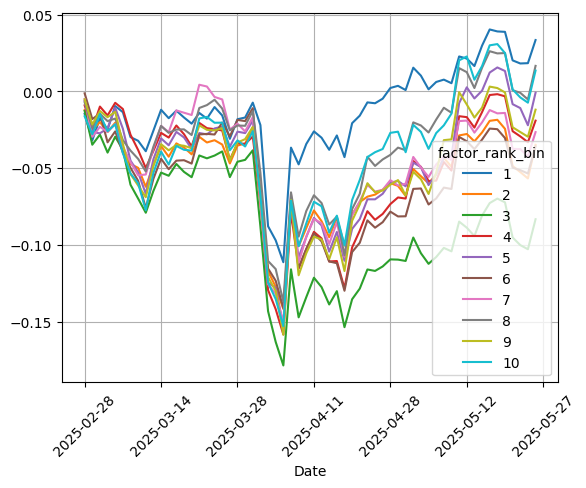

In [ ]:
(test.groupby(['factor_rank_bin', \
        'Date']).ret1.mean()-1).unstack().T.cumsum().plot(rot=45,grid=True)

<Axes: xlabel='Date'>

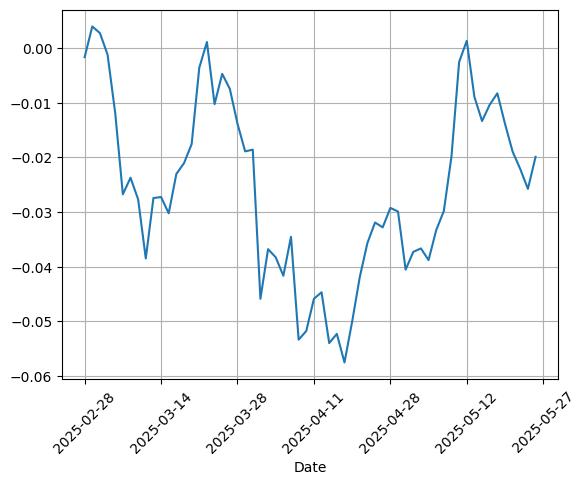

In [ ]:

long_ret = (test[(test.factor_rank_bin == 10)].groupby('Date').ret1.mean()-1).cumsum()
short_ret = (test[(test.factor_rank_bin == 1)].groupby('Date').ret1.mean()-1).cumsum()
(long_ret - short_ret).plot(rot=45,grid=True)

In [ ]:
ret_PD = (test.groupby(['factor_rank_bin', 'Date']).ret1.mean()-1.00).unstack().T

if ret_PD[1].mean()>ret_PD[10].mean():
    ret_PD['diff'] = ret_PD[1] - ret_PD[10]
else:
    ret_PD['diff'] = ret_PD[10] - ret_PD[1]


In [ ]:

def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = returns.index[dd.argmin()]
    start = returns.index[r.loc[:end].argmax()]
    return mdd, start, end





def calc_pfmc(ret_PD):
    performance = []
    for i in [1,2,3,4,5,6,7,8,9,10,'diff']:
        returnlist = ret_PD[i]
        ret_year = (returnlist.mean()-0)*252
        ret_sharpe = (returnlist.mean()-0)/returnlist.std()*(252**0.5)
        max_draw, start, end = max_dd(returnlist)
        winratio = (returnlist>0).sum()/len(returnlist)
        std = returnlist.std()
        performance.append([i,ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])
    return performance

calc_pfmc(ret_PD)

,group_name,return,sharpe,std,winratio,mdd
0,1,0.140711,0.542028,0.016353,0.459016,-0.104808
1,2,-0.146216,-0.565107,0.016299,0.475410,-0.131313
2,3,-0.349843,-1.280457,0.017211,0.459016,-0.168073
3,4,-0.079934,-0.268569,0.018749,0.426230,-0.152132
4,5,-0.003499,-0.011673,0.018881,0.491803,-0.147450
5,6,-0.150429,-0.518509,0.018276,0.459016,-0.140188
6,7,-0.111353,-0.358447,0.019569,0.459016,-0.154472
7,8,0.069979,0.245257,0.017974,0.475410,-0.132484
8,9,-0.049891,-0.153936,0.020416,0.459016,-0.154277
9,10,0.057159,0.183279,0.019646,0.508197,-0.140326


<ipython-input-72-299a8f4b0a98>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = tmp.groupby('Date').apply(lambda x: x.sort_values('pred', ascending = False).head(num)).reset_index(drop=True)


<Axes: title={'center': '2024-2025 year'}, xlabel='Date'>

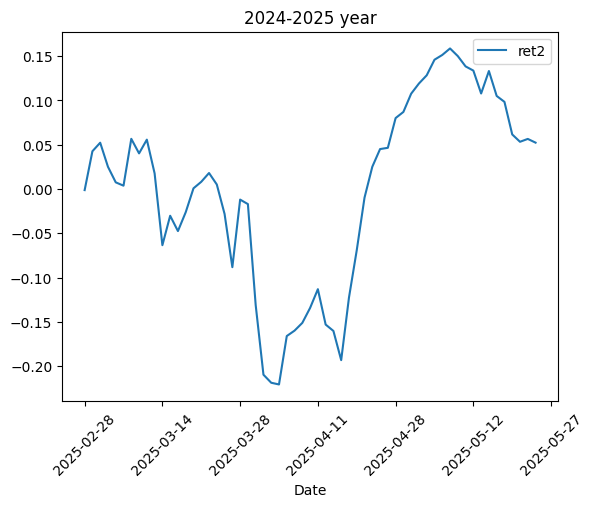

In [ ]:
tmp = test.copy()
tmp = tmp[(tmp.open_up<1.05)&(tmp.open_up>0.95)]
num = 10
tmp = tmp.groupby('Date').apply(lambda x: x.sort_values('pred', ascending = False).head(num)).reset_index(drop=True)
ret_pd1 = pd.DataFrame(tmp.groupby('Date').ret2.mean() - 1.0005)
(ret_pd1.loc['2024-05-08':,] ).cumsum().plot(rot=45, title = '2024-2025 year')

In [ ]:
def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min().values[0]
    end = returns.index[dd.values.argmin()]
    start = returns.index[r.loc[:end].values.argmax()]
    return mdd, start, end


def calc_pfmc(ret_PD):
    ret_PD_ = ret_PD.copy()
    performance = []
    ret_PD_.columns = ['ret']
    returnlist = ret_PD_['ret']
    ret_year = (returnlist.mean())*252
    ret_sharpe = (returnlist.mean())/returnlist.std()*((252)**0.5)

    winratio = (returnlist>0).sum()/(returnlist!=0).sum()
    std = returnlist.std()

    ret2_len = pd.DataFrame(tmp.groupby('Date').ret.count())
    ret2_len = ret2_len.reindex(date_calc).fillna(0)
    stock_pct = ret2_len.mean().values[0]
    max_draw, start, end = max_dd(ret_PD)
    performance.append(['LGB',ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])



    return performance

In [ ]:
calc_pfmc(ret_pd1)

,group_name,return,sharpe,std,winratio,mdd
0,LGB,0.223664,0.397912,0.035409,0.508197,-0.262477


In [ ]:
tmp[tmp.Date=='2025-03-27'][['Ticker','Date','pred','ret','ret1','ret2']].head(10)

,Ticker,Date,pred,ret,ret1,ret2
190,TSLA,2025-03-27,13.477993,0.940417,0.964925,0.940417
191,TSLA,2025-03-27,13.477993,0.940417,0.964925,0.940417
192,TSLA,2025-03-27,13.477993,0.940417,0.964925,0.940417
193,TSLA,2025-03-27,13.477993,0.940417,0.964925,0.940417
194,TSLA,2025-03-27,13.477993,0.940417,0.964925,0.940417
195,TSLA,2025-03-27,13.477993,0.940417,0.964925,0.940417
196,TSLA,2025-03-27,13.477993,0.940417,0.964925,0.940417
197,TSLA,2025-03-27,13.477993,0.940417,0.964925,0.940417
198,TSLA,2025-03-27,13.477993,0.940417,0.964925,0.940417
199,TSLA,2025-03-27,13.477993,0.940417,0.964925,0.940417


In [ ]:
tmp

,Ticker,Date,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha_volume_ratio,alpha_vwap,alpha_dv_ttm,ret1,ret2,ret,open_up,pred,factor_rank,factor_rank_bin
0,K,2025-02-28,0.000004,0.000785,8.754849e-07,0.000006,-0.000002,0.000045,0.000015,0.000056,...,NaN,0.121462,NaN,0.996502,0.999272,0.999272,0.996622,11.966284,1.0,10
1,K,2025-02-28,0.000004,0.000785,8.754849e-07,0.000006,-0.000002,0.000045,0.000015,0.000056,...,NaN,0.121462,NaN,0.996502,0.999272,0.999272,0.996622,11.966284,1.0,10
2,K,2025-02-28,0.000004,0.000785,8.754849e-07,0.000006,-0.000002,0.000045,0.000015,0.000056,...,NaN,0.121462,NaN,0.996502,0.999272,0.999272,0.996622,11.966284,1.0,10
3,K,2025-02-28,0.000004,0.000785,8.754849e-07,0.000006,-0.000002,0.000045,0.000015,0.000056,...,NaN,0.121462,NaN,0.996502,0.999272,0.999272,0.996622,11.966284,1.0,10
4,K,2025-02-28,0.000004,0.000785,8.754849e-07,0.000006,-0.000002,0.000045,0.000015,0.000056,...,NaN,0.121462,NaN,0.996502,0.999272,0.999272,0.996622,11.966284,1.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,UNH,2025-05-27,-0.000596,0.044107,3.445438e-04,-0.000884,-0.086729,0.014306,0.014306,0.229695,...,1.40926,0.033898,-2.84,NaN,NaN,NaN,1.003729,12.889697,1.0,10
606,UNH,2025-05-27,-0.000596,0.044107,3.445438e-04,-0.000884,-0.086729,0.014306,0.014306,0.229695,...,1.40926,0.033898,-2.84,NaN,NaN,NaN,1.003729,12.889697,1.0,10
607,UNH,2025-05-27,-0.000596,0.044107,3.445438e-04,-0.000884,-0.086729,0.014306,0.014306,0.229695,...,1.40926,0.033898,-2.84,NaN,NaN,NaN,1.003729,12.889697,1.0,10
608,UNH,2025-05-27,-0.000596,0.044107,3.445438e-04,-0.000884,-0.086729,0.014306,0.014306,0.229695,...,1.40926,0.033898,-2.84,NaN,NaN,NaN,1.003729,12.889697,1.0,10


In [ ]:
import yfinance as yf

dfindex = yf.download(tickers='^SPX', start='2025-02-28',end='2025-05-27')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
dfindex['ret'] = dfindex[('Close', '^SPX')].pct_change()
dfindex

Price,Close,High,Low,Open,Volume,ret
Ticker,^SPX,^SPX,^SPX,^SPX,^SPX,
Date,,,,,,
2025-02-28,5954.500000,5959.399902,5837.660156,5856.740234,6441140000,NaN
2025-03-03,5849.720215,5986.089844,5810.910156,5968.330078,5613850000,-0.017597
2025-03-04,5778.149902,5865.080078,5732.589844,5811.979980,6138110000,-0.012235
2025-03-05,5842.629883,5860.589844,5742.350098,5781.359863,5285970000,0.011159
2025-03-06,5738.520020,5812.080078,5711.640137,5785.870117,5165080000,-0.017819
2025-03-07,5770.200195,5783.009766,5666.290039,5726.009766,5705140000,0.005521
2025-03-10,5614.560059,5705.370117,5564.020020,5705.370117,6409370000,-0.026973
2025-03-11,5572.069824,5636.299805,5528.410156,5603.649902,6221240000,-0.007568


In [ ]:
# Calculate pct_change for ('Close', '^SPX')
pct_chg = dfindex[('Close', '^SPX')].pct_change()

# Create DataFrame with Date as a column and pct_chg as another
result = pct_chg.rename('pct_chg').reset_index()
result.columns = ['Date', 'pct_chg']  # Ensure column names are as desired

dfindex = result.set_index('Date')
# dfindex


In [ ]:
# print(ret_pd1.index)
# print(dfindex.index)
# print(ret_pd1.index.dtype)
# print(dfindex.index.dtype)
# For ret_pd1 (object/string index)
ret_pd1.index = pd.to_datetime(ret_pd1.index)

# For dfindex (optional, if already DatetimeIndex, but safe)
dfindex.index = pd.to_datetime(dfindex.index)


In [ ]:
# ret_pd_concat = pd.concat([ret_pd1, dfindex], axis=1)
ret_pd_concat = pd.merge(ret_pd1,dfindex,left_index=True, right_index=True)
ret_pd_concat

,ret2,pct_chg
Date,,
2025-02-28,-0.001228,NaN
2025-03-03,0.043877,-0.017597
2025-03-04,0.009639,-0.012235
2025-03-05,-0.027186,0.011159
2025-03-06,-0.017567,-0.017819
2025-03-07,-0.003773,0.005521
2025-03-10,0.052911,-0.026973
2025-03-11,-0.016433,-0.007568
2025-03-12,0.015517,0.004887


In [ ]:
# ret_pd_concat = pd.merge(ret_pd1,dfindex*100,left_index=True, right_index=True)
ret_pd_concat = pd.concat([ret_pd1, dfindex], axis=1)
ret_pd_concat.columns = ['ret','dfindex']
ret_pd_concat['diff'] = ret_pd_concat['ret'] - ret_pd_concat['dfindex']
ret_pd_concat

,ret,dfindex,diff
Date,,,
2025-02-28,-0.001228,NaN,NaN
2025-03-03,0.043877,-0.017597,0.061474
2025-03-04,0.009639,-0.012235,0.021874
2025-03-05,-0.027186,0.011159,-0.038345
2025-03-06,-0.017567,-0.017819,0.000252
...,...,...,...
2025-05-20,-0.008284,-0.003880,-0.004403
2025-05-21,0.003249,-0.016135,0.019384
2025-05-22,-0.004215,-0.000445,-0.003770


In [ ]:
ret_pd_concat.corr()

,ret,dfindex,diff
ret,1.000000,-0.051536,0.870471
dfindex,-0.051536,1.000000,-0.536427
diff,0.870471,-0.536427,1.000000


<Axes: title={'center': '2022-2024 year'}, xlabel='Date'>

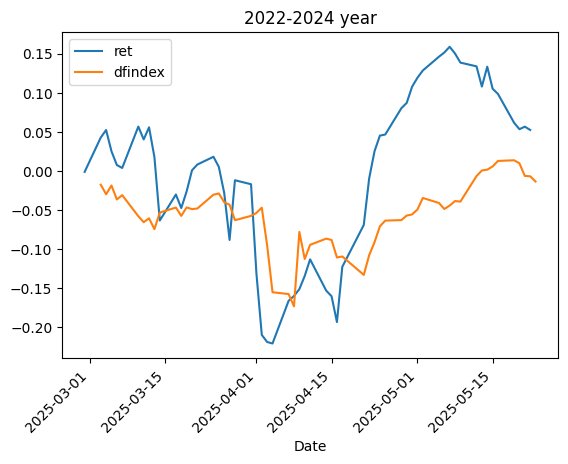

In [ ]:
(ret_pd_concat[['ret','dfindex']].cumsum()).plot(rot=45, title = '2022-2024 year')


In [ ]:
calc_pfmc(ret_pd_concat[['diff']])

,group_name,return,sharpe,std,winratio,mdd
0,LGB,0.262612,0.391413,0.042265,0.47541,-0.249706
